In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE, RandomOverSampler, SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

In [ ]:
df = pd.read_csv("ML_DATASET.csv")

In [3]:
df['attrition'] = (
    (df['KPIs_met_more_than_80'] == 0) &
    (df['avg_training_score'] < 60) &
    (df['length_of_service'] > 5) &
    (df['previous_year_rating'] <= 2) &
    (df['awards_won'] == 0)
).astype(int)

print(df['attrition'].value_counts())
print(df['attrition'].value_counts(normalize=True) * 100)


attrition
0    16658
1      759
Name: count, dtype: int64
attrition
0    95.642189
1     4.357811
Name: proportion, dtype: float64


In [4]:
df

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met_more_than_80,awards_won,avg_training_score,attrition
0,8724,Technology,region_26,Bachelors,m,sourcing,1,24,NaN,1,1,0,77,0
1,74430,HR,region_4,Bachelors,f,other,1,31,3.0,5,0,0,51,0
2,72255,Sales & Marketing,region_13,Bachelors,m,other,1,31,1.0,4,0,0,47,0
3,38562,Procurement,region_2,Bachelors,f,other,3,31,2.0,9,0,0,65,0
4,64486,Finance,region_29,Bachelors,m,sourcing,1,30,4.0,7,0,0,61,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17412,64573,Technology,region_7,Bachelors,f,referred,2,30,5.0,6,1,0,81,0
17413,49584,HR,region_7,Bachelors,m,other,1,33,1.0,9,0,0,51,1
17414,49584,HR,region_7,Bachelors,m,other,1,33,1.0,9,0,0,51,1
17415,49584,HR,region_7,Bachelors,m,other,1,33,1.0,9,0,0,51,1


In [5]:
df_encoded = df.copy()

In [6]:
att_cols = ['KPIs_met_more_than_80', 'avg_training_score', 'length_of_service', 'previous_year_rating', 'awards_won']
X = df.drop(columns=['attrition'] + att_cols)
y = df['attrition']

In [7]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as SklearnPipeline


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

categorical_cols = ['department', 'recruitment_channel', 'region', 'education', 'gender']
numerical_cols = list(set(X.columns) - set(categorical_cols))

cat_pipe = SklearnPipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])
num_pipe = SklearnPipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, categorical_cols),
    ('num', num_pipe, numerical_cols)
])

In [9]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    #('under', RandomUnderSampler(random_state=42)),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])

param_grid = {
    'classifier__C': [0.1, 1, 10]
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Best Params:", grid_search.best_params_)
print("\n Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Params: {'classifier__C': 0.1}

 Confusion Matrix:
 [[2383  949]
 [  27  125]]


In [10]:
best_log_model = grid_search.best_estimator_

y_pred_log = best_log_model.predict(X_test)

print("\n Classification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_log))


 Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.99      0.72      0.83      3332
           1       0.12      0.82      0.20       152

    accuracy                           0.72      3484
   macro avg       0.55      0.77      0.52      3484
weighted avg       0.95      0.72      0.80      3484



In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline as SklearnPipeline
from imblearn.pipeline import Pipeline  
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

categorical_cols = ['department', 'recruitment_channel', 'region', 'education', 'gender']
numerical_cols = list(set(X.columns) - set(categorical_cols))

cat_pipe = SklearnPipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

num_pipe = SklearnPipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('cat', cat_pipe, categorical_cols),
    ('num', num_pipe, numerical_cols)
])

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

rf_param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10, None],
    'classifier__min_samples_split': [2, 5]
}

rf_grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_param_grid,
    scoring='f1_macro',
    cv=5,
    verbose=1,
    n_jobs=-1
)

rf_grid_search.fit(X_train, y_train)

best_rf_model = rf_grid_search.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)

print(" Best Params (Random Forest):", rf_grid_search.best_params_)
print("\n Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\n Classification Report:\n", classification_report(y_test, y_pred_rf))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
 Best Params (Random Forest): {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}

 Confusion Matrix:
 [[2830  502]
 [  45  107]]

 Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.85      0.91      3332
           1       0.18      0.70      0.28       152

    accuracy                           0.84      3484
   macro avg       0.58      0.78      0.60      3484
weighted avg       0.95      0.84      0.88      3484



In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline as SklearnPipeline
from imblearn.pipeline import Pipeline  
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

categorical_cols = ['department', 'recruitment_channel', 'region', 'education', 'gender']
numerical_cols = list(set(X.columns) - set(categorical_cols))

cat_pipe = SklearnPipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

num_pipe = SklearnPipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('cat', cat_pipe, categorical_cols),
    ('num', num_pipe, numerical_cols)
])

dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

dt_param_grid = {
    'classifier__max_depth': [5, 10, 20, None],
    'classifier__min_samples_split': [2, 5, 10]
}

dt_grid_search = GridSearchCV(
    estimator=dt_pipeline,
    param_grid=dt_param_grid,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=1
)

dt_grid_search.fit(X_train, y_train)

best_dt_model = dt_grid_search.best_estimator_
y_pred_dt = best_dt_model.predict(X_test)

print(" Best Params (Decision Tree):", dt_grid_search.best_params_)
print("\n Confusion Matrix (Decision Tree):\n", confusion_matrix(y_test, y_pred_dt))
print("\n Classification Report (Decision Tree):\n", classification_report(y_test, y_pred_dt))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
 Best Params (Decision Tree): {'classifier__max_depth': 20, 'classifier__min_samples_split': 10}

 Confusion Matrix (Decision Tree):
 [[2967  365]
 [  70   82]]

 Classification Report (Decision Tree):
               precision    recall  f1-score   support

           0       0.98      0.89      0.93      3332
           1       0.18      0.54      0.27       152

    accuracy                           0.88      3484
   macro avg       0.58      0.71      0.60      3484
weighted avg       0.94      0.88      0.90      3484



In [13]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline as SklearnPipeline
from imblearn.pipeline import Pipeline  
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

categorical_cols = ['department', 'recruitment_channel', 'region', 'education', 'gender']
numerical_cols = list(set(X.columns) - set(categorical_cols))

cat_pipe = SklearnPipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

num_pipe = SklearnPipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('cat', cat_pipe, categorical_cols),
    ('num', num_pipe, numerical_cols)
])

svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', SVC(probability=True, random_state=42))
])

svm_param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': ['scale', 'auto'] 
}

svm_grid_search = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=svm_param_grid,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=1
)

svm_grid_search.fit(X_train, y_train)

best_svm_model = svm_grid_search.best_estimator_
y_pred_svm = best_svm_model.predict(X_test)

print(" Best Params (SVM):", svm_grid_search.best_params_)
print("\n Confusion Matrix (SVM):\n", confusion_matrix(y_test, y_pred_svm))
print("\n Classification Report (SVM):\n", classification_report(y_test, y_pred_svm))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
 Best Params (SVM): {'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}

 Confusion Matrix (SVM):
 [[2865  467]
 [  70   82]]

 Classification Report (SVM):
               precision    recall  f1-score   support

           0       0.98      0.86      0.91      3332
           1       0.15      0.54      0.23       152

    accuracy                           0.85      3484
   macro avg       0.56      0.70      0.57      3484
weighted avg       0.94      0.85      0.88      3484



In [17]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

models = {
    "Logistic Regression": best_log_model,
    "Random Forest": best_rf_model,
    "Decision Tree": best_dt_model,
    "SVM": best_svm_model
}

metrics = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    metrics.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    })

metrics_df = pd.DataFrame(metrics)
print(" Model Comparison:")
display(metrics_df.style.set_caption("Model Evaluation Metrics").format({
    "Accuracy": "{:.2%}",
    "Precision": "{:.2%}",
    "Recall": "{:.2%}",
    "F1 Score": "{:.2%}"
}))

 Model Comparison:


,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,71.99%,11.64%,82.24%,20.39%
1,Random Forest,84.30%,17.57%,70.39%,28.12%
2,Decision Tree,87.51%,18.34%,53.95%,27.38%
3,SVM,84.59%,14.94%,53.95%,23.40%


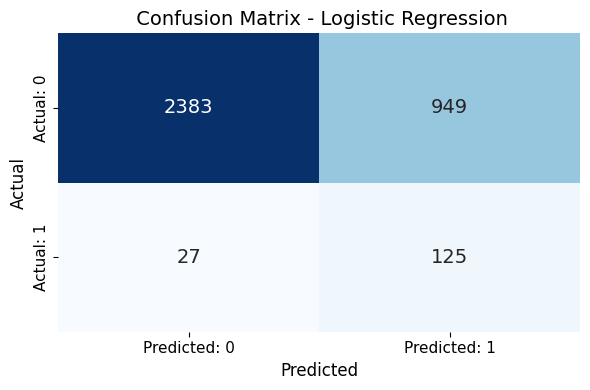

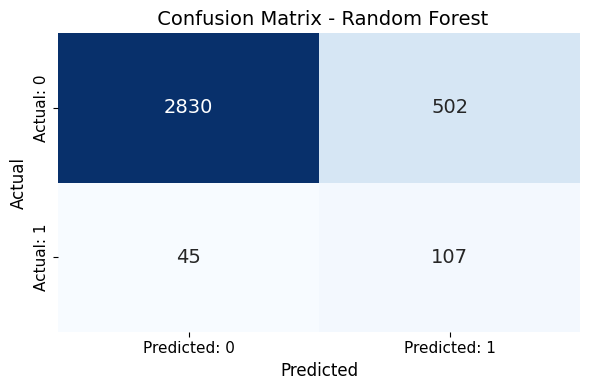

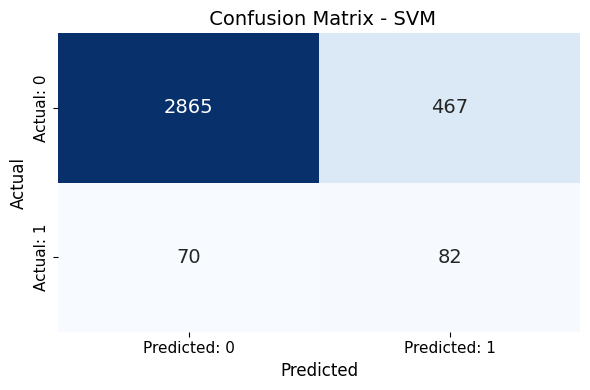

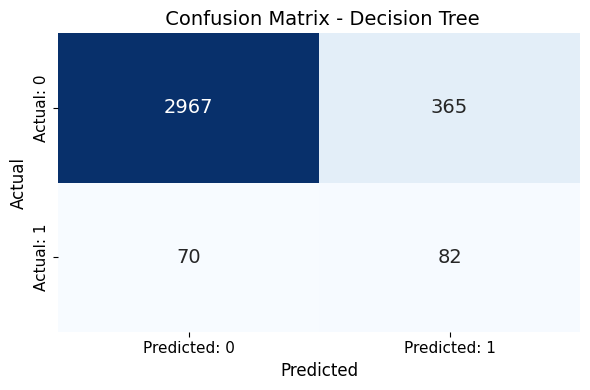

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

def plot_conf_matrix(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=['Actual: 0', 'Actual: 1'], columns=['Predicted: 0', 'Predicted: 1'])
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 14})
    plt.title(f" Confusion Matrix - {model_name}", fontsize=14)
    plt.ylabel('Actual', fontsize=12)
    plt.xlabel('Predicted', fontsize=12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.tight_layout()
    plt.show()

plot_conf_matrix(y_test, y_pred_log, "Logistic Regression")
plot_conf_matrix(y_test, y_pred_rf, "Random Forest")
plot_conf_matrix(y_test, y_pred_svm, "SVM")
plot_conf_matrix(y_test, y_pred_dt, "Decision Tree")


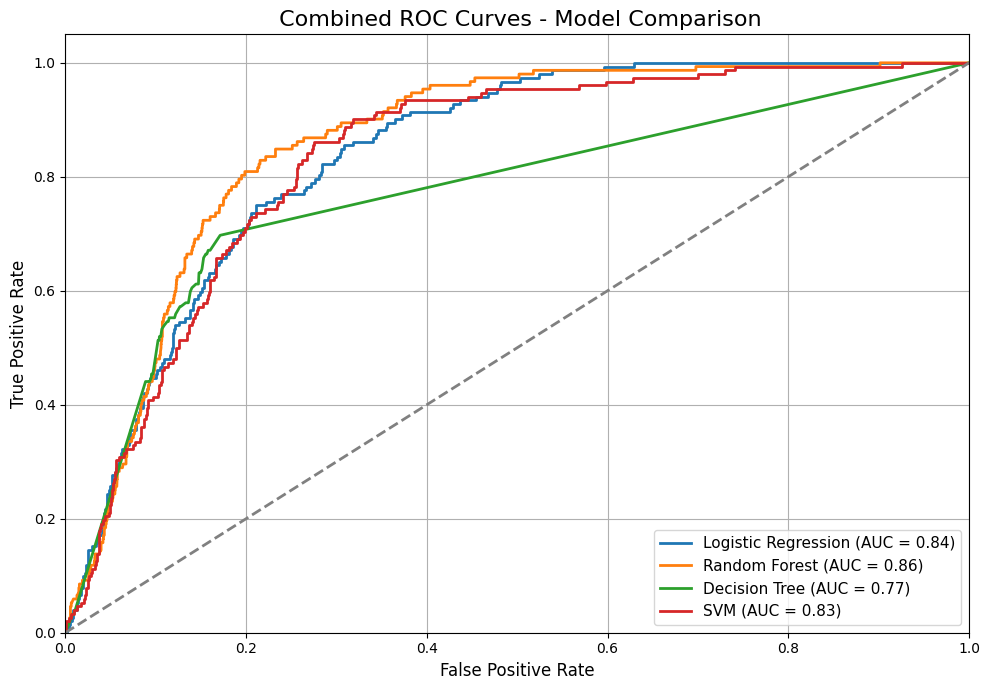

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

proba_dict = {
    "Logistic Regression": best_log_model.predict_proba(X_test)[:, 1],
    "Random Forest": best_rf_model.predict_proba(X_test)[:, 1],
    "Decision Tree": best_dt_model.predict_proba(X_test)[:, 1],
    "SVM": best_svm_model.decision_function(X_test)
}

def plot_combined_roc(y_test, proba_dict):
    """
    y_test: Ground truth labels
    proba_dict: Dictionary of model name to predicted probabilities or scores
    """
    plt.figure(figsize=(10, 7))

    for model_name, y_score in proba_dict.items():
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(' Combined ROC Curves - Model Comparison', fontsize=16)
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_combined_roc(y_test, proba_dict)